In [34]:
import pandas as pd

# Load your dataset
df = pd.read_csv("PDA.csv")

# See what’s inside
print(df.shape)
print(df.columns.tolist())

# Look at rows
df.head()


(170317, 21)
['YEAR', 'AGECAT', 'SEX', 'MARRIED', 'EDUCAT', 'EMPLOY18', 'CTYMETRO', 'HEALTH', 'MENTHLTH', 'PRLMISEVR', 'PRLMISAB', 'PRLANY', 'HEROINEVR', 'HEROINUSE', 'TRQLZRS', 'SEDATVS', 'COCAINE', 'AMPHETMN', 'HALUCNG', 'TRTMENT', 'MHTRTMT']


,YEAR,AGECAT,SEX,MARRIED,EDUCAT,EMPLOY18,CTYMETRO,HEALTH,MENTHLTH,PRLMISEVR,...,PRLANY,HEROINEVR,HEROINUSE,TRQLZRS,SEDATVS,COCAINE,AMPHETMN,HALUCNG,TRTMENT,MHTRTMT
0,15,3,1,0,2,2,0,3,4,1,...,10,1,5,5,0,5,2,2,6,0
1,15,3,0,0,3,1,0,6,7,1,...,10,1,5,5,0,4,3,5,5,0
2,15,2,0,0,3,0,0,4,2,1,...,9,1,5,5,0,4,2,3,7,2
3,15,1,0,0,1,0,0,5,0,1,...,9,1,5,5,0,3,2,2,0,0
4,15,5,0,0,3,0,0,5,2,1,...,9,1,5,5,3,2,2,2,7,0


In [35]:
# EDIT THESE COLUMN NAMES based on your df.columns
MISUSE_COL   = "PAINRELIEVER_MISUSE"   # 0/1
AGE_COL      = "AGE"
SEX_COL      = "SEX"
MENTAL_COL   = "MENTALHLTH"
HEROIN_COL   = "HEROIN_USE"
COCAINE_COL  = "COCAINE_USE"
MARIJUANA_COL = "MARIJUANA_USE"

In [36]:
from dataclasses import dataclass
import numpy as np

@dataclass
class Agent:
    id: int
    age: int
    sex: int
    mental_health: float
    previous_misuse: int
    other_drug_use: float
    p_base: float
    using: bool = False

In [37]:
MISUSE_COL    = "PRLANY"
AGE_COL       = "AGECAT"
SEX_COL       = "SEX"
MENTAL_COL    = "MENTHLTH"

HEROIN_COL    = "HEROINUSE"
COCAINE_COL   = "COCAINE"
MARIJUANA_COL = "AMPHETMN"   # used as proxy

In [38]:
# Keep only the needed columns
cols = [MISUSE_COL, AGE_COL, SEX_COL, MENTAL_COL,
        HEROIN_COL, COCAINE_COL, MARIJUANA_COL]

df_small = df[cols].dropna().copy()

# Combine drug use
df_small["OTHER_DRUG_USE"] = (
    df_small[HEROIN_COL] +
    df_small[COCAINE_COL] +
    df_small[MARIJUANA_COL]
)

# Standardization constants
mental_mean = df_small[MENTAL_COL].mean()
mental_std  = df_small[MENTAL_COL].std()
other_mean  = df_small["OTHER_DRUG_USE"].mean()
other_std   = df_small["OTHER_DRUG_USE"].std()

def compute_baseline_prob(row):
    base = 0.05

    if row[MISUSE_COL] == 1:
        base += 0.35

    mental_z = (row[MENTAL_COL] - mental_mean) / (mental_std + 1e-6)
    other_z  = (row["OTHER_DRUG_USE"] - other_mean) / (other_std + 1e-6)

    base += 0.05 * mental_z
    base += 0.05 * other_z

    return float(np.clip(base, 0.01, 0.95))

# Build agents list
agents = []
for i, row in df_small.iterrows():
    p_base = compute_baseline_prob(row)
    agent = Agent(
        id=int(i),
        age=int(row[AGE_COL]),
        sex=int(row[SEX_COL]),
        mental_health=float(row[MENTAL_COL]),
        previous_misuse=int(row[MISUSE_COL]),
        other_drug_use=float(row["OTHER_DRUG_USE"]),
        p_base=p_base
    )
    agents.append(agent)

print(f"Created {len(agents)} agents.")

Created 170317 agents.


In [39]:
import copy
import math

rng = np.random.default_rng(42)

def run_simulation(agents, T=50, with_resources=False, k=0.02):
    sim_agents = [copy.deepcopy(a) for a in agents]
    misuse_rates = []

    if with_resources:
        for a in sim_agents:
            if a.p_base > 0.3:
                if rng.random() < 0.6:
                    rehab_days = rng.integers(10, 90)
                    adjusted_p = a.p_base * math.exp(-k * rehab_days)
                    a.p_base = float(np.clip(adjusted_p, 0.01, 0.95))

    for t in range(T):
        misuse_count = 0
        for a in sim_agents:
            a.using = rng.random() < a.p_base
            if a.using:
                misuse_count += 1

        misuse_rate = misuse_count / len(sim_agents)
        misuse_rates.append(misuse_rate)

    return misuse_rates

T = 50
misuse_baseline  = run_simulation(agents, T=T, with_resources=False)
misuse_resources = run_simulation(agents, T=T, with_resources=True)

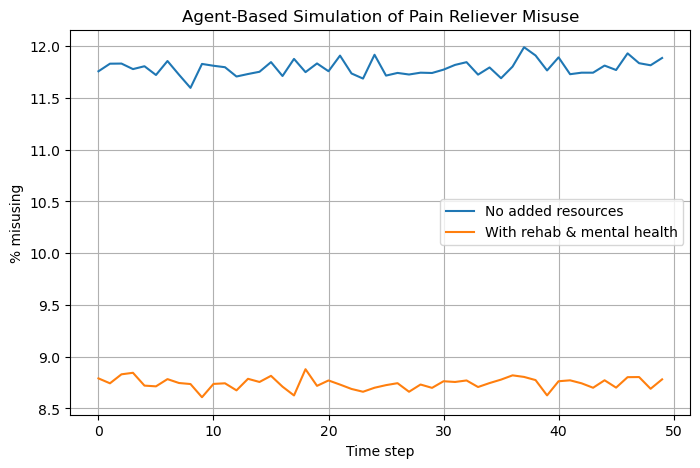

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))
plt.plot(range(T), np.array(misuse_baseline) * 100, label="No added resources")
plt.plot(range(T), np.array(misuse_resources) * 100, label="With rehab & mental health")
plt.xlabel("Time step")
plt.ylabel("% misusing")
plt.title("Agent-Based Simulation of Pain Reliever Misuse")
plt.legend()
plt.grid(True)
plt.show()

Summary Table:
              Misuse Rate  Users Count
HEROINEVR        4.092339         3433
HEROINUSE        3.206965         5346
TRQLZRS         10.000000        38149
SEDATVS          2.642458         8738
COCAINE          1.415630        30565
AMPHETMN         1.351627        26199
HALUCNG          1.255655        55855
ANY_DRUG_USE     1.404186        47248


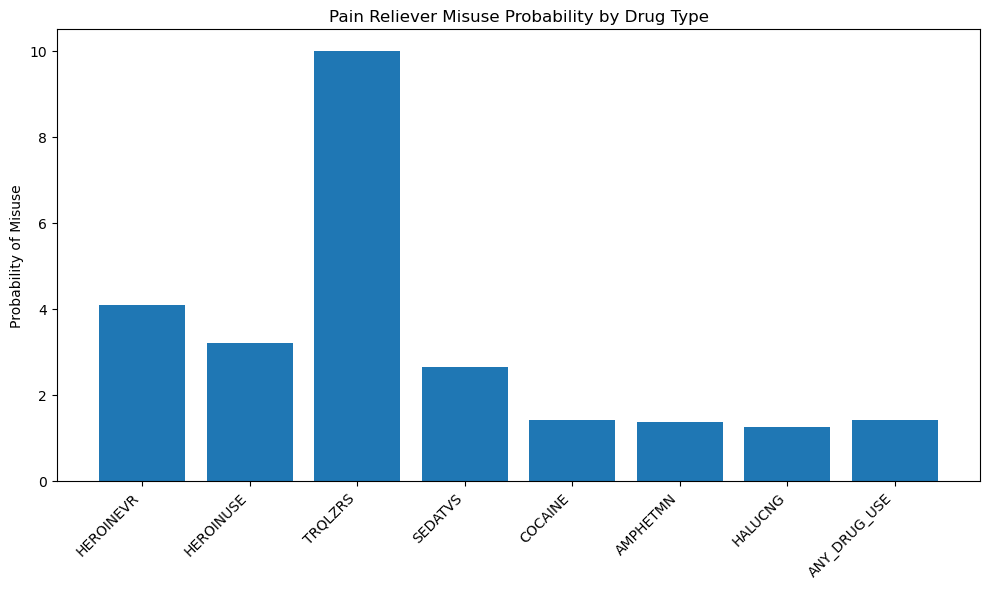

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("PDA.csv")

# ---- STEP 1: Correct column names ----
MISUSE_COL = "PRLMISAB"
AGE_COL = "AGECAT"
SEX_COL = "SEX"
MENTAL_COL = "MENTHLTH"

DRUG_COLS = [
    "HEROINEVR",
    "HEROINUSE",
    "TRQLZRS",
    "SEDATVS",
    "COCAINE",
    "AMPHETMN",
    "HALUCNG"
]

# ---- STEP 2: Filter dataset ----
df_small = df[[MISUSE_COL, AGE_COL, SEX_COL, MENTAL_COL] + DRUG_COLS].copy()
df_small = df_small.dropna()

# Convert drug columns to integer 0/1
for col in DRUG_COLS:
    df_small[col] = df_small[col].astype(int)

# ---- STEP 3: Combined ANY drug-use variable ----
df_small["ANY_DRUG_USE"] = df_small[DRUG_COLS].sum(axis=1).clip(upper=1)

# ---- STEP 4: Compute misuse rates for each drug ----
misuse_rates = {
    drug: df_small.loc[df_small[drug] == 1, MISUSE_COL].mean()
    for drug in DRUG_COLS
}

# Add combined rate
misuse_rates["ANY_DRUG_USE"] = df_small.loc[df_small["ANY_DRUG_USE"] == 1, MISUSE_COL].mean()

# ---- STEP 5: Create summary table ----
summary_table = pd.DataFrame({
    "Misuse Rate": misuse_rates,
    "Users Count": {drug: df_small[drug].sum() for drug in misuse_rates}
})

print("Summary Table:")
print(summary_table)

# ---- STEP 6: Plot ----
plt.figure(figsize=(10,6))
plt.bar(summary_table.index, summary_table["Misuse Rate"])
plt.title("Pain Reliever Misuse Probability by Drug Type")
plt.ylabel("Probability of Misuse")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()